# Imports

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


2025-11-13 02:43:05.402358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load & merge raw Ask/Bid data

In [2]:
import pandas as pd
from IPython.display import display



ASK_CSV = "XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv"
BID_CSV = "XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv"

df_ask = pd.read_csv(ASK_CSV)
df_bid = pd.read_csv(BID_CSV)


print("Ask raw:", df_ask.shape)
print("Bid raw:", df_bid.shape)


# Clean column names
df_ask.columns = df_ask.columns.str.strip()
df_bid.columns = df_bid.columns.str.strip()

# Standardise timestamp column
df_ask = df_ask.rename(columns={'Time (UTC)': 'timestamp', 'Time(UTC)': 'timestamp'})
df_bid = df_bid.rename(columns={'Time (UTC)': 'timestamp', 'Time(UTC)': 'timestamp'})

# Convert to datetime
df_ask['timestamp'] = pd.to_datetime(df_ask['timestamp'], format='%Y.%m.%d %H:%M:%S')
df_bid['timestamp'] = pd.to_datetime(df_bid['timestamp'], format='%Y.%m.%d %H:%M:%S')

# Rename Ask columns
df_ask = df_ask.rename(columns={
    'Open': 'Open_Ask',
    'High': 'High_Ask',
    'Low': 'Low_Ask',
    'Close': 'Close_Ask',
    'Volume': 'Volume_Ask'
})

# Rename Bid columns
df_bid = df_bid.rename(columns={
    'Open': 'Open_Bid',
    'High': 'High_Bid',
    'Low': 'Low_Bid',
    'Close': 'Close_Bid',
    'Volume': 'Volume_Bid'
})

# Merge on timestamp
df_merged = df_bid.merge(df_ask, on='timestamp', how='inner')

# Sort by time
df_merged = df_merged.sort_values("timestamp").reset_index(drop=True)

# ===========================
# VISUAL DISPLAY LIKE SCREENSHOT
# ===========================

def grey_white_rows(row):
    colour = '#f5f5f5' if row.name % 2 else 'white'
    return [f'background-color: {colour}'] * len(row)

# Styled head
styled_head = (
    df_merged.head(5)
             .style
             .apply(grey_white_rows, axis=1)
             .set_table_styles([
                 {'selector': 'th',
                  'props': [('background-color', '#e6e6e6'),
                            ('font-weight', 'bold'),
                            ('border-bottom', '1px solid #ccc')]}
             ])
)

# Styled tail
styled_tail = (
    df_merged.tail(5)
             .style
             .apply(grey_white_rows, axis=1)
             .set_table_styles([
                 {'selector': 'th',
                  'props': [('background-color', '#e6e6e6'),
                            ('font-weight', 'bold'),
                            ('border-bottom', '1px solid #ccc')]}
             ])
)

print("Merged shape:", df_merged.shape)

display(styled_head)
print("...\n...\n...")
display(styled_tail)

# Optional: Save merged file
df_merged.to_csv("MergedDataset.csv", index=False, encoding="utf-8")


Ask raw: (35220, 6)
Bid raw: (35220, 6)
Merged shape: (35220, 11)


,timestamp,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask
0,2023-01-02 23:00:00,24.036000,24.059000,24.017000,24.059000,0.348000,24.102000,24.125000,24.083000,24.125000,0.351000
1,2023-01-02 23:05:00,24.064000,24.130000,24.064000,24.092000,1.845800,24.094000,24.188000,24.094000,24.141000,1.155000
2,2023-01-02 23:10:00,24.094000,24.098000,23.972000,23.977000,0.903000,24.143000,24.148000,24.022000,24.027000,0.882000
3,2023-01-02 23:15:00,23.977000,23.980000,23.938000,23.980000,0.894000,24.026000,24.028000,23.986000,24.028000,0.894000
4,2023-01-02 23:20:00,23.978000,24.024000,23.976000,24.023000,0.888000,24.026000,24.073000,24.023000,24.073000,0.904400


...
...
...


,timestamp,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask
35215,2023-06-30 20:35:00,22.752000,22.752000,22.741000,22.746000,0.275200,22.782000,22.782000,22.771000,22.776000,1.800200
35216,2023-06-30 20:40:00,22.736000,22.751000,22.736000,22.746000,0.141000,22.775000,22.781000,22.775000,22.776000,0.756800
35217,2023-06-30 20:45:00,22.751000,22.751000,22.746000,22.746000,0.069000,22.781000,22.781000,22.776000,22.776000,0.421200
35218,2023-06-30 20:50:00,22.746000,22.761000,22.736000,22.756000,0.216000,22.776000,22.797000,22.774000,22.786000,0.683600
35219,2023-06-30 20:55:00,22.756000,22.766000,22.701000,22.745000,0.327000,22.786000,22.811000,22.786000,22.811000,0.371200


# Basic info + visualisations (Week 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35220 entries, 0 to 35219
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   35220 non-null  datetime64[ns]
 1   Open_Bid    35220 non-null  float64       
 2   High_Bid    35220 non-null  float64       
 3   Low_Bid     35220 non-null  float64       
 4   Close_Bid   35220 non-null  float64       
 5   Volume_Bid  35220 non-null  float64       
 6   Open_Ask    35220 non-null  float64       
 7   High_Ask    35220 non-null  float64       
 8   Low_Ask     35220 non-null  float64       
 9   Close_Ask   35220 non-null  float64       
 10  Volume_Ask  35220 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 3.0 MB
None
              count                           mean                  min  \
timestamp     35220  2023-04-02 13:17:53.202725888  2023-01-02 23:00:00   
Open_Bid    35220.0                      23.357365  

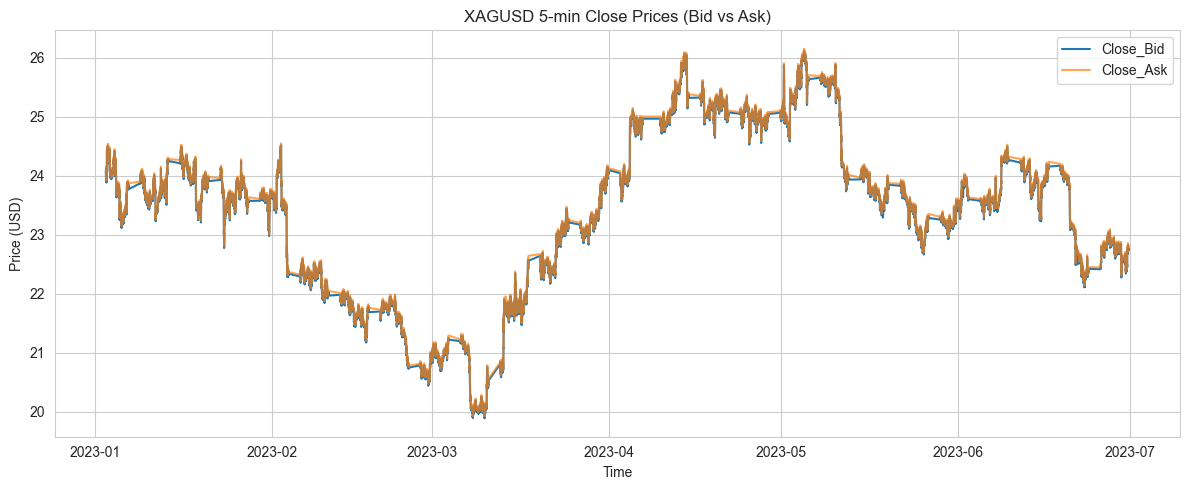

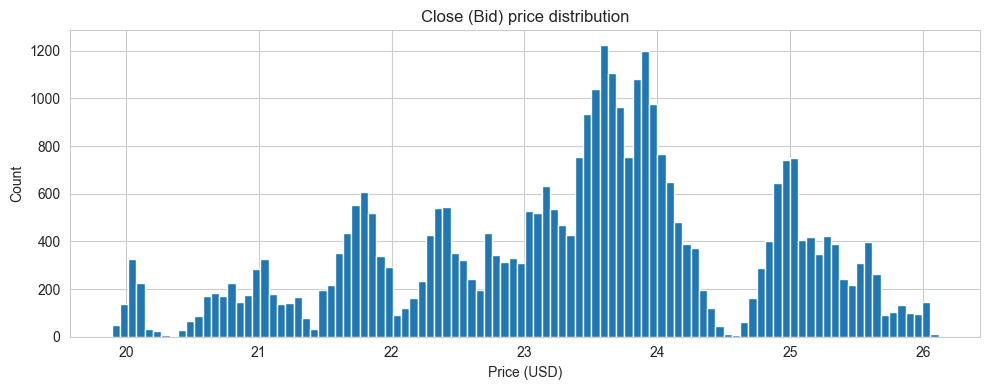

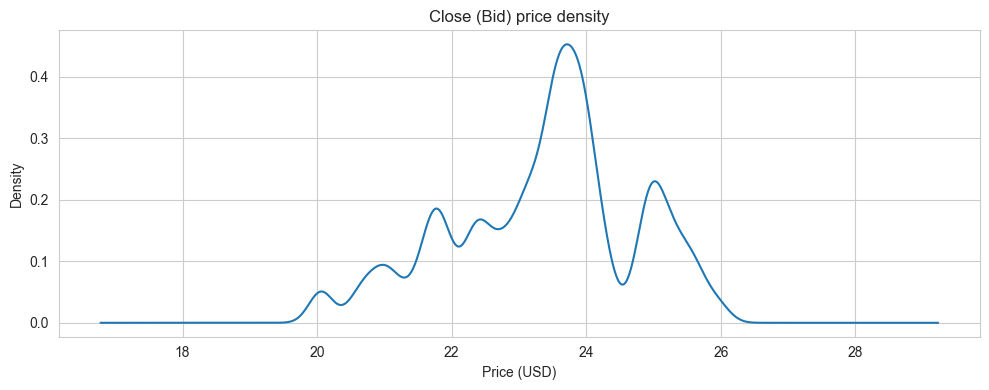

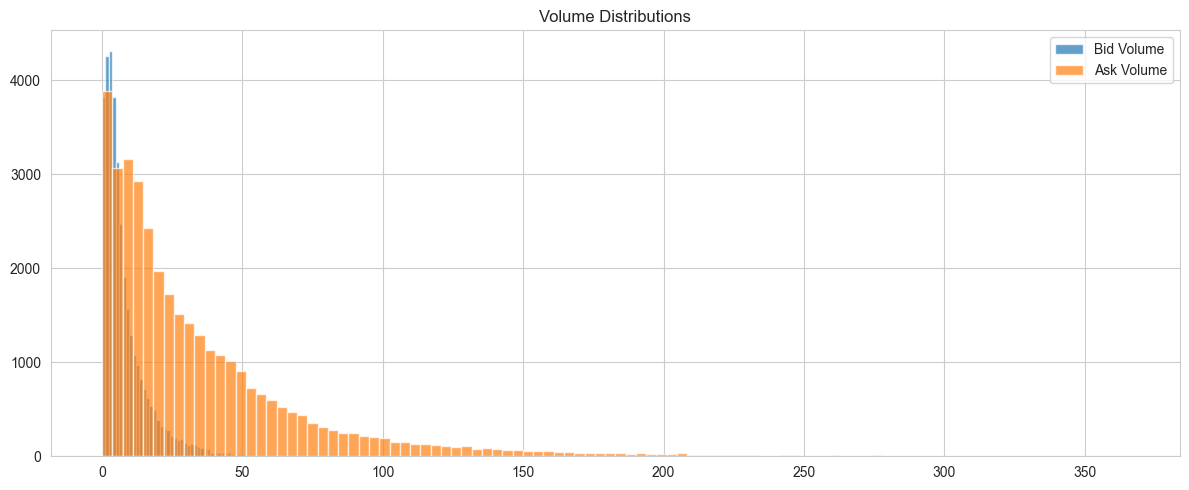

In [3]:
import matplotlib.pyplot as plt

# use the merged dataframe
df = df_merged.copy()



print(df.info())
print(df.describe().T)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(
    df['timestamp'],
    format='%Y.%m.%d %H:%M:%S',
    utc=True,
    errors='coerce'
)

# --- Price chart (Close Bid & Ask) ---
plt.figure(figsize=(12,5))
plt.plot(df['timestamp'], df['Close_Bid'], label='Close_Bid')
plt.plot(df['timestamp'], df['Close_Ask'], label='Close_Ask', alpha=0.7)
plt.title('XAGUSD 5-min Close Prices (Bid vs Ask)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Histogram of Close_Bid ---
plt.figure(figsize=(10,4))
plt.hist(df['Close_Bid'], bins=100)
plt.title('Close (Bid) price distribution')
plt.xlabel('Price (USD)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# --- KDE of Close_Bid ---
plt.figure(figsize=(10,4))
df['Close_Bid'].dropna().plot(kind='kde')
plt.title('Close (Bid) price density')
plt.xlabel('Price (USD)')
plt.tight_layout()
plt.show()

# --- Volume distributions ---
plt.figure(figsize=(12,5))
plt.hist(df['Volume_Bid'], bins=100, alpha=0.7, label='Bid Volume')
plt.hist(df['Volume_Ask'], bins=100, alpha=0.7, label='Ask Volume')
plt.title('Volume Distributions')
plt.legend()
plt.tight_layout()
plt.show()


#  Feature engineering 
   Deltas, volume delta, day/week markers

In [4]:
# =========================================
# 4. Feature engineering (Week 6 style)
#    - Deltas, volume delta, day/week markers
# =========================================

data = df.copy()

# Volume deltas
data['Volume_Delta'] = data['Volume_Ask'] - data['Volume_Bid']
data['Volume_Delta_abs'] = data['Volume_Delta'].abs()

# Price deltas (Ask - Bid)
data['Open_Delta']  = data['Open_Ask']  - data['Open_Bid']
data['High_Delta']  = data['High_Ask']  - data['High_Bid']
data['Low_Delta']   = data['Low_Ask']   - data['Low_Bid']
data['Close_Delta'] = data['Close_Ask'] - data['Close_Bid']

# Time column
data['Local_time_T'] = data['timestamp']  # keep same idea as GOLD example

# Time delta vs previous row
data['Local_time_T_shift_1_down'] = data['Local_time_T'].shift(1)
data['Local_time_T_Delta'] = data['Local_time_T'] - data['Local_time_T_shift_1_down']
data['Local_time_T_Delta_min'] = data['Local_time_T_Delta'].dt.total_seconds() / 60.0

# New day & New week flags (gaps > 1 minute / > 1 day)
data['New_day'] = 0
data['New_week'] = 0

data.loc[data['Local_time_T_Delta'] > pd.Timedelta(minutes=1), 'New_day'] = 1
data.loc[data['Local_time_T_Delta'] > pd.Timedelta(days=1), 'New_week'] = 1

print(data.info())
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35220 entries, 0 to 35219
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  35220 non-null  datetime64[ns, UTC]
 1   Open_Bid                   35220 non-null  float64            
 2   High_Bid                   35220 non-null  float64            
 3   Low_Bid                    35220 non-null  float64            
 4   Close_Bid                  35220 non-null  float64            
 5   Volume_Bid                 35220 non-null  float64            
 6   Open_Ask                   35220 non-null  float64            
 7   High_Ask                   35220 non-null  float64            
 8   Low_Ask                    35220 non-null  float64            
 9   Close_Ask                  35220 non-null  float64            
 10  Volume_Ask                 35220 non-null  float64            
 11  Vo

,timestamp,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,...,Open_Delta,High_Delta,Low_Delta,Close_Delta,Local_time_T,Local_time_T_shift_1_down,Local_time_T_Delta,Local_time_T_Delta_min,New_day,New_week
0,2023-01-02 23:00:00+00:00,24.036,24.059,24.017,24.059,0.3480,24.102,24.125,24.083,24.125,...,0.066,0.066,0.066,0.066,2023-01-02 23:00:00+00:00,NaT,NaT,NaN,0,0
1,2023-01-02 23:05:00+00:00,24.064,24.130,24.064,24.092,1.8458,24.094,24.188,24.094,24.141,...,0.030,0.058,0.030,0.049,2023-01-02 23:05:00+00:00,2023-01-02 23:00:00+00:00,0 days 00:05:00,5.0,1,0
2,2023-01-02 23:10:00+00:00,24.094,24.098,23.972,23.977,0.9030,24.143,24.148,24.022,24.027,...,0.049,0.050,0.050,0.050,2023-01-02 23:10:00+00:00,2023-01-02 23:05:00+00:00,0 days 00:05:00,5.0,1,0
3,2023-01-02 23:15:00+00:00,23.977,23.980,23.938,23.980,0.8940,24.026,24.028,23.986,24.028,...,0.049,0.048,0.048,0.048,2023-01-02 23:15:00+00:00,2023-01-02 23:10:00+00:00,0 days 00:05:00,5.0,1,0
4,2023-01-02 23:20:00+00:00,23.978,24.024,23.976,24.023,0.8880,24.026,24.073,24.023,24.073,...,0.048,0.049,0.047,0.050,2023-01-02 23:20:00+00:00,2023-01-02 23:15:00+00:00,0 days 00:05:00,5.0,1,0


In [5]:


data['Y_High_Bid'] = data['High_Bid']
data['Y_Low_Ask']  = data['Low_Ask']   # = Low_Bid + Low_Delta implicitly

data[['High_Bid', 'Low_Ask', 'Y_High_Bid', 'Y_Low_Ask']].head()


,High_Bid,Low_Ask,Y_High_Bid,Y_Low_Ask
0,24.059,24.083,24.059,24.083
1,24.130,24.094,24.130,24.094
2,24.098,24.022,24.098,24.022
3,23.980,23.986,23.980,23.986
4,24.024,24.023,24.024,24.023


# Normalisation:

In [6]:

feature_cols = [
    'Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid',
    'Volume_Bid', 'Volume_Ask',
    'Volume_Delta', 'Volume_Delta_abs',
    'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta',
    'New_day', 'New_week'
]

target_cols = ['Y_High_Bid', 'Y_Low_Ask']

# Work on a clean copy
data2 = data[feature_cols + target_cols].copy()

print("Raw data2 shape:", data2.shape)

# --- Train / test split along time axis (rows) ---
data_length = len(data2)
train_size_rows = int(data_length * 0.8)
print("Total rows:", data_length, "Train rows:", train_size_rows)

train = data2.iloc[:train_size_rows]

# ---- Price limits (like Week 6) ----
max_price = (train['High_Bid'] + train['High_Delta']).max()
min_price = train['Low_Bid'].min()

# ---- Volume limits ----
max_volume = max(train['Volume_Bid'].max(), train['Volume_Ask'].max())
min_volume = 0.0

# ---- Delta limits ----
max_Delta = train[['Open_Delta','High_Delta','Low_Delta','Close_Delta']].max().max()
min_Delta = train[['Open_Delta','High_Delta','Low_Delta','Close_Delta']].min().min()

max_volume_Delta = train['Volume_Delta'].max()
min_volume_Delta = train['Volume_Delta'].min()

max_volume_Delta_abs = train['Volume_Delta_abs'].max()
min_volume_Delta_abs = 0.0  # absolute

# To avoid division by zero
def safe_den(a, b):
    den = a - b
    if den == 0:
        den = 1.0
    return den

den_price = safe_den(max_price, min_price)
den_volume = safe_den(max_volume, min_volume)
den_Delta = safe_den(max_Delta, min_Delta)
den_vDelta = safe_den(max_volume_Delta, min_volume_Delta)
den_vDelta_abs = safe_den(max_volume_Delta_abs, min_volume_Delta_abs)

# ---- Apply normalisation (same formula as Week 6, but once, cleanly) ----

# Prices (Bid + targets)
for col in ['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Y_High_Bid', 'Y_Low_Ask']:
    data2[col] = (data2[col] - min_price) / den_price

# Volumes
for col in ['Volume_Bid', 'Volume_Ask']:
    data2[col] = (data2[col] - min_volume) / den_volume

# Volume deltas
data2['Volume_Delta'] = (data2['Volume_Delta'] - min_volume_Delta) / den_vDelta
data2['Volume_Delta_abs'] = (data2['Volume_Delta_abs'] - min_volume_Delta_abs) / den_vDelta_abs

# Price deltas (inverted normalisation, as per Week 6 formula)
for col in ['Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta']:
    data2[col] = (max_Delta - data2[col]) / den_Delta

# New_day / New_week leave as 0/1 (no scaling)

# Clean any numeric nasties
data2.replace([np.inf, -np.inf], np.nan, inplace=True)
data2.dropna(inplace=True)
data2.reset_index(drop=True, inplace=True)

print("✅  Normalised data2 shape:", data2.shape)
print(data2.describe().T[['min','max']].round(3))


Raw data2 shape: (35220, 16)
Total rows: 35220 Train rows: 28176
✅  Normalised data2 shape: (35220, 16)
                    min    max
Open_Bid          0.001  0.994
High_Bid          0.004  0.995
Low_Bid           0.000  0.991
Close_Bid         0.001  0.994
Volume_Bid        0.000  0.330
Volume_Ask        0.000  1.000
Volume_Delta      0.000  1.000
Volume_Delta_abs  0.000  1.000
Open_Delta        0.403  0.968
High_Delta        0.282  0.945
Low_Delta        -0.325  1.000
Close_Delta       0.000  0.964
New_day           0.000  1.000
New_week          0.000  1.000
Y_High_Bid        0.004  0.995
Y_Low_Ask         0.005  0.996


# Separate Inputs (X) and Outputs (y)

In [7]:
print(data2.columns.tolist())

['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 'Volume_Ask', 'Volume_Delta', 'Volume_Delta_abs', 'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta', 'New_day', 'New_week', 'Y_High_Bid', 'Y_Low_Ask']


In [8]:


features = [
    'Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid',
    'Volume_Bid', 'Volume_Ask',
    'Volume_Delta', 'Volume_Delta_abs',
    'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta',
    'New_day', 'New_week'
]

targets = ['Y_High_Bid', 'Y_Low_Ask']

# Convert to numpy arrays
X = data2[features].values.astype('float32')
y = data2[targets].values.astype('float32')

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (35220, 14)
y shape: (35220, 2)


# Create 3D Tensor

In [9]:
from tqdm import tqdm
import numpy as np

n_small = X.shape[0]     # total rows after normalisation
t = X.shape[1]           # number of features
N = 50                   # window size (same as GOLD Week-7)

future_step = 5          # 5 intervals * 5 minutes = 25 minutes ahead

# number of sliding windows (make sure we have room for +future_step)
L = n_small - N - future_step

print('Future step (minutes ahead): ', future_step * 5)
print('Size of a three-dimensional inputs tensor: ', L, N, t)
print('L = n_small - N - future_step = ', n_small - N - future_step, L)

# create inputs 3D tensor and target matrix
data_b = np.zeros((L, N, t), dtype='float32')
Y      = np.zeros((L, 2),    dtype='float32')

# fill the inputs 3D tensor (data_b) and the array of answers Y
for k in tqdm(range(L)):
    data_b[k, :, :] = X[k:k+N, :]

    # targets 25 minutes in the future
    Y[k, 0] = y[k + N - 1 + future_step, 0]   # Y_High_Bid 25 min ahead
    Y[k, 1] = y[k + N - 1 + future_step, 1]   # Y_Low_Ask 25 min ahead

# index value for control (same as original)
print("Last k:", k)

# full tensor + shapes + Y head/tail like in the HTML export
print('data_b:\n', data_b)
print("Numpy size (data_b):\t", data_b.shape, '\n')

print("Y head:\n", Y[:5, :])
print("Y tail:\n", Y[-10:, :])
print("Numpy size (Y):\t", Y.shape)


Future step (minutes ahead):  25
Size of a three-dimensional inputs tensor:  35165 50 14
L = n_small - N - future_step =  35165 35165


100%|█████████████████████████████████| 35165/35165 [00:00<00:00, 113443.79it/s]

Last k: 35164
data_b:
 [[[0.66209096 0.6657622  0.6590583  ... 0.78896105 0.         0.        ]
  [0.66656023 0.677095   0.66656023 ... 0.84415585 1.         0.        ]
  [0.67134875 0.67198724 0.6518755  ... 0.84090906 1.         0.        ]
  ...
  [0.69114125 0.6964086  0.6901836  ... 0.90584415 1.         0.        ]
  [0.6936951  0.6970471  0.6914605  ... 0.90584415 1.         0.        ]
  [0.6952913  0.7122107  0.694174   ... 0.90584415 1.         0.        ]]

 [[0.66656023 0.677095   0.66656023 ... 0.84415585 1.         0.        ]
  [0.67134875 0.67198724 0.6518755  ... 0.84090906 1.         0.        ]
  [0.6526736  0.6531524  0.64644855 ... 0.8474026  1.         0.        ]
  ...
  [0.6936951  0.6970471  0.6914605  ... 0.90584415 1.         0.        ]
  [0.6952913  0.7122107  0.694174   ... 0.90584415 1.         0.        ]
  [0.7114126  0.7122107  0.7056664  ... 0.90584415 1.         0.        ]]

 [[0.67134875 0.67198724 0.6518755  ... 0.84090906 1.         0.        ]

In [10]:


import random

# pp is a random starting index, but far enough from the end
pp = random.randint(50, L - 20)   # L = number of sequences

print('random int =', pp)
print('data_b:\t\t\tY:')
print('X last-step col[1]\tY_High_Bid')  # feature index 1 = High_Bid (in your features order)

for i in range(15):
    # value from the last time step (N-1) of the window, feature index 1 (High_Bid)
    x_val = data_b[pp + i, N - 1, 1]
    # corresponding Y value (Y_High_Bid)
    y_val = Y[pp + i, 0]
    print(x_val, '\t\t', y_val)


random int = 27682
data_b:			Y:
X last-step col[1]	Y_High_Bid
0.56839585 		 0.55913806
0.56903434 		 0.55131686
0.56264967 		 0.5509976
0.5647247 		 0.5481245
0.5685555 		 0.548763
0.55913806 		 0.54940146
0.55131686 		 0.54110134
0.5509976 		 0.5403033
0.5481245 		 0.5383879
0.548763 		 0.5363129
0.54940146 		 0.5367917
0.54110134 		 0.5331205
0.5403033 		 0.5254589
0.5383879 		 0.52402234
0.5363129 		 0.52881086


In [11]:
data=[]
data_ax=[]
data_ay=[]
data_a=[]
data_y=[]

# Multi-Layer Perceptron

Flatten the 3D tensor to 2D

In [12]:
# flatten the 3D tensor so MLP can use it
X_flat = data_b.reshape(data_b.shape[0], -1)

print("Flattened shape:", X_flat.shape)


Flattened shape: (35165, 700)


# Train Test Split
80% for training and validation
20% for testing

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# CORRECT train-test split for MLP
X_train, X_test, y_train, y_test = train_test_split(
    X_flat,     # ✅ the flattened 2D data
    Y,          # still the same target
    test_size=0.2,
    shuffle=False,
    stratify=None,
    random_state=101
)


In [15]:
print(X_train.shape) 
print(X_test.shape)   
print(y_train.shape)   


(28132, 700)
(7033, 700)
(28132, 2)


# Training MLP

In [17]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2)   # 2 outputs: High_Bid, Low_Ask
])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               358912    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 523394 (2.00 MB)
Trainable params: 523394 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Callbacks

In [18]:
model.compile(optimizer="adam",loss="mse",metrics=["mae"])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1
)

mc = ModelCheckpoint(
    'best_model_MLP_Silver.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)


In [20]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc]
)


Epoch 1/20
789/792 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0246
Epoch 1: val_loss improved from inf to 0.00032, saving model to best_model_MLP_Silver.keras
792/792 [==============================] - 8s 8ms/step - loss: 0.0039 - mae: 0.0246 - val_loss: 3.1817e-04 - val_mae: 0.0154
Epoch 2/20
786/792 [============================>.] - ETA: 0s - loss: 4.0902e-04 - mae: 0.0152
Epoch 2: val_loss did not improve from 0.00032
792/792 [==============================] - 6s 8ms/step - loss: 4.1089e-04 - mae: 0.0152 - val_loss: 3.8826e-04 - val_mae: 0.0169
Epoch 3/20
788/792 [============================>.] - ETA: 0s - loss: 3.3430e-04 - mae: 0.0137
Epoch 3: val_loss improved from 0.00032 to 0.00012, saving model to best_model_MLP_Silver.keras
792/792 [==============================] - 6s 7ms/step - loss: 3.3367e-04 - mae: 0.0137 - val_loss: 1.1965e-04 - val_mae: 0.0080
Epoch 4/20
784/792 [============================>.] - ETA: 0s - loss: 2.7266e-04 - mae: 0.0122
Epoch 

In [21]:
from tensorflow import keras  # only if not already imported

MLP_saved_best_model = keras.models.load_model('best_model_MLP_Silver.keras')


# Test

In [ ]:
# Evaluate the quality of network training on test data
scores = MLP_saved_best_model.evaluate(X_test, y_test, verbose=1)

scores


In [ ]:
print("Mean squared error (mse): %.9f " % (scores[0]))


In [ ]:
print("Mean absolute error (mae): %.9f " % (scores[1]))


# Visualisation
# MSE training graphs

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Mean Squared Error',size=14)
plt.show()

In [ ]:
# More detailed MSE graph

history_dict = history.history

mse_values = history_dict['loss']
val_mse_values = history_dict['val_loss']

epochs = range(1, len(mse_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mse_values, 'b', label='Training Mean Squared Error (MSE)')
plt.plot(epochs, val_mse_values, marker='o', markeredgecolor='red', markerfacecolor='yellow', label='Validation Mean Squared Error (MSE)')
plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Squared Error (MSE)', size=18)
plt.legend()
plt.show()

In [ ]:
# deleted the 1st epoch
# to examine in detail the results of the remaining epochs

history_dict = history.history

mse_values = history_dict['loss'][1:]
val_mse_values = history_dict['val_loss'][1:]

epochs = range(1, len(mse_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mse_values, 'b', label='Training Mean Squared Error (MSE)')
plt.plot(epochs, val_mse_values, marker='o', markeredgecolor='red', markerfacecolor='yellow', label='Validation Mean Squared Error (MSE)')
plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Squared Error (MSE)', size=18)
plt.legend()
plt.show()

# MAE training graphs

In [ ]:
plt.plot(history.history['mae'])
plt.xlabel('Mean Absolute error',size=14)
plt.show()

# More Detailed Graph MAE

In [ ]:
history_dict = history.history
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']

epochs = range(1, len(mae_values) + 1)

plt.figure(num=1, figsize=(15, 7))
plt.plot(epochs, mae_values, 'b', label='Training Mean Absolute Error (MAE)')
plt.plot(epochs, val_mae_values, marker='o', markeredgecolor='green',
         markerfacecolor='yellow', label='Validation Mean Absolute Error (MAE)')

plt.xlabel('Epochs', size=18)
plt.ylabel('Mean Absolute Error (MAE)', size=18)
plt.legend()
plt.show()

# Using the neural network to predict the price 25 min ahead

In [22]:
pred= MLP_saved_best_model(X_test)
print(pred)

tf.Tensor(
[[0.47513098 0.4824539 ]
 [0.47411287 0.48220375]
 [0.47658893 0.48351958]
 ...
 [0.4535468  0.4607695 ]
 [0.4534533  0.46077248]
 [0.45373166 0.4606929 ]], shape=(7033, 2), dtype=float32)


# Price chart

220/220 [==============================] - 1s 2ms/step


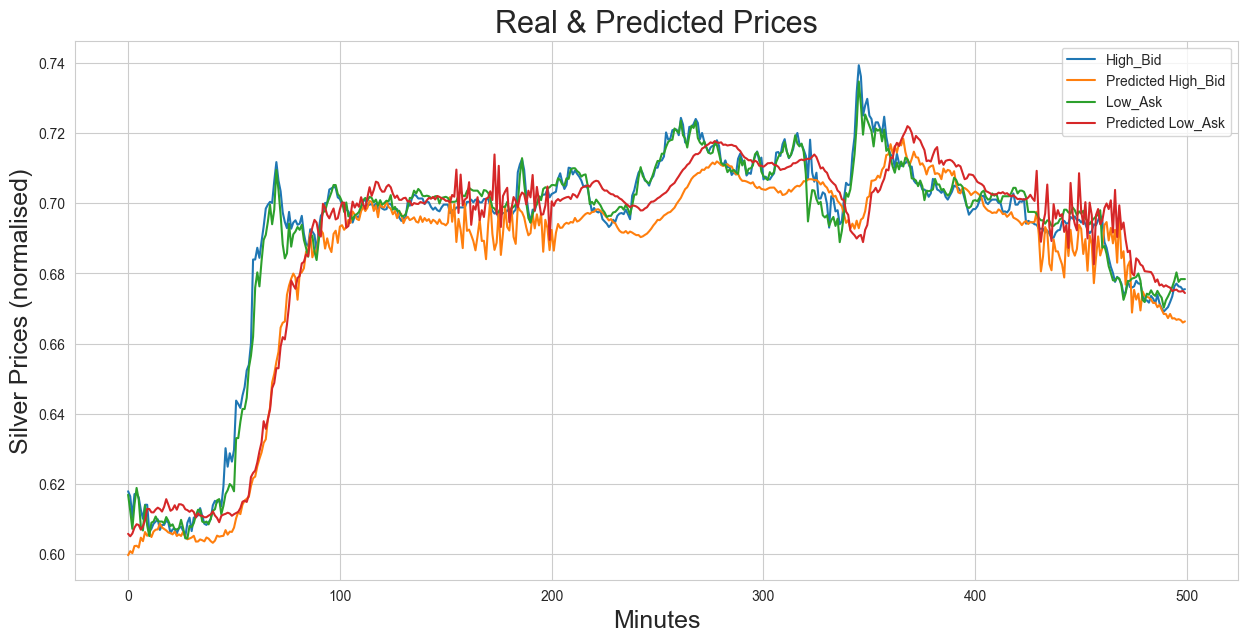

In [27]:
import matplotlib.pyplot as plt

# Get predictions from the saved best model
pred = MLP_saved_best_model.predict(X_test)

# Chart window
N1 = 2500   # first index for the chart (sequence index in test set)
LL = 500    # number of points to show
N2 = N1 + LL

plt.ion()
fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(111)

line1, = ax1.plot(y_test[N1:N2, 0], label='High_Bid')
line2, = ax1.plot(pred[N1:N2, 0], label='Predicted High_Bid')
line3, = ax1.plot(y_test[N1:N2, 1], label='Low_Ask')
line4, = ax1.plot(pred[N1:N2, 1], label='Predicted Low_Ask')

plt.title('Real & Predicted Prices', size=22)
plt.ylabel('Silver Prices (normalised)', size=18)
plt.xlabel('Minutes', size=18)
plt.legend(loc='upper right')

plt.show()


# Error Chart

In [31]:
# ======================================================
# Get min, max and average Close_Bid price on TRAIN set
# (analog of 1614.71 and 2020.778 in the template)
# ======================================================

# use your merged dataframe; if you only have df_merged, then do: df = df_merged.copy()
# df should have a 'Close_Bid' column in ORIGINAL (unnormalised) prices
n_rows = len(df)
train_end = int(0.8 * n_rows)      # 80% for training

df_train_real = df.iloc[:train_end]   # training part of original data

min_price = df_train_real["Close_Bid"].min()
max_price = df_train_real["Close_Bid"].max()
average_price = (max_price + min_price) / 2

print("min_price  :", min_price)
print("max_price  :", max_price)
print("avg_price  :", average_price)



min_price  : 19.893
max_price  : 26.118
avg_price  : 23.005499999999998


=== Real price ranges ===
High_real  true min/max: 22.111742 24.495426
High_real  pred min/max: 22.077522 24.365047
Low_real   true min/max: 22.118698 24.46661
Low_real   pred min/max: 22.134815 24.387318
Training min_price: 19.893
Training max_price: 26.118

=== Spot check at index 100 ===
Normalised High  (y_test): 0.5265762
Restored  High   (true)  : 23.170937
Normalised High  (pred):  0.52082586
Restored  High   (pred)  : 23.135141

=== Error stats in $ ===
High_Bid error  mean / max: 0.056043405 0.29003143
Low_Ask  error  mean / max: 0.04323922 0.230196


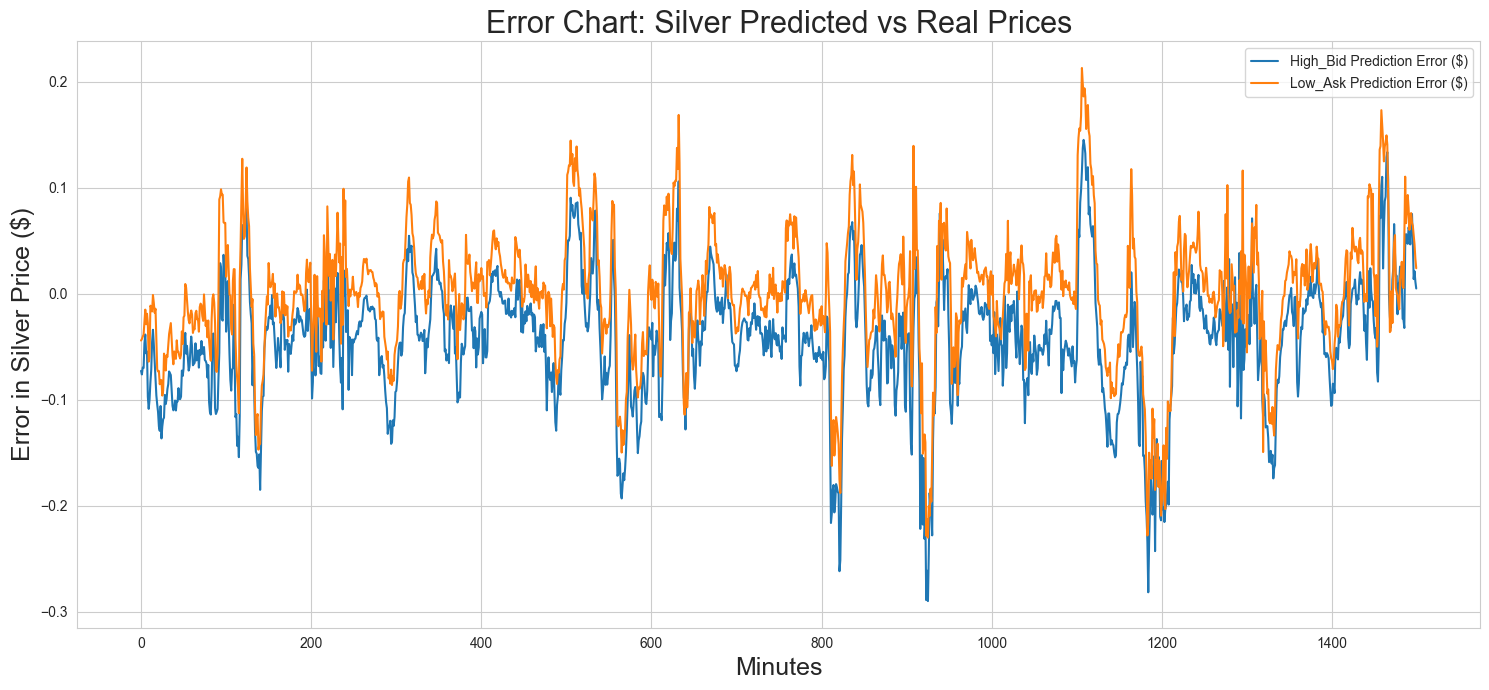

In [35]:
# # ============================================
# # Error Chart for SILVER (absolute $ error)
# # Using Min-Max values from TRAIN dataset
# # ============================================

# # average price (used only if % error needed)
# average_price = (max_price + min_price) / 2

# # Select chart range
# N1 = 0                 # first index in test set
# LL = 1500              # number of samples to plot
# N2 = N1 + LL           # must be < len(pred)

# plt.ion()
# fig = plt.figure(figsize=(15, 7))
# ax1 = fig.add_subplot(111)

# # -------------------------------------------------------
# # Absolute error in REAL SILVER PRICE ($)
# # -------------------------------------------------------
# # Step 1: restore normalised values to true prices

# # Restore real predicted prices
# pred_High_real = pred[:,0] * (max_price - min_price) + min_price
# pred_Low_real  = pred[:,1] * (max_price - min_price) + min_price

# # Restore real test prices
# y_High_real = y_test[:,0] * (max_price - min_price) + min_price
# y_Low_real  = y_test[:,1] * (max_price - min_price) + min_price

# # Step 2: compute real absolute errors
# a = pred_High_real[N1:N2] - y_High_real[N1:N2]   # High_Bid error ($)
# b = pred_Low_real[N1:N2]  - y_Low_real[N1:N2]    # Low_Ask error ($)

# # -------------------------------------------------------
# # If you want PERCENT ERROR instead, uncomment this:
# # a = (a / average_price) * 100
# # b = (b / average_price) * 100
# # -------------------------------------------------------

# # Plot
# ax1.plot(a, label='High_Bid Prediction Error ($)')
# ax1.plot(b, label='Low_Ask Prediction Error ($)')

# plt.title('Error Chart: Silver Predicted vs Real Prices', fontsize=22)
# plt.ylabel('Error in Silver Price ($)', fontsize=18)
# plt.xlabel('Minutes', fontsize=18)
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# ============================================
# Error Chart for SILVER (absolute $ error)
# + sanity checks to confirm values are real
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# average price (only needed for % error if you want)
average_price = (max_price + min_price) / 2

# Select chart range
N1 = 0
LL = 1500
N2 = N1 + LL

# -----------------------------
# 1) Restore real prices
# -----------------------------
pred_High_real = pred[:,0] * (max_price - min_price) + min_price
pred_Low_real  = pred[:,1] * (max_price - min_price) + min_price

y_High_real = y_test[:,0] * (max_price - min_price) + min_price
y_Low_real  = y_test[:,1] * (max_price - min_price) + min_price

# -----------------------------
# DEBUG CHECK #1: ranges
# -----------------------------
print("=== Real price ranges ===")
print("High_real  true min/max:", y_High_real.min(), y_High_real.max())
print("High_real  pred min/max:", pred_High_real.min(), pred_High_real.max())
print("Low_real   true min/max:", y_Low_real.min(), y_Low_real.max())
print("Low_real   pred min/max:", pred_Low_real.min(), pred_Low_real.max())
print("Training min_price:", min_price)
print("Training max_price:", max_price)

# -----------------------------
# DEBUG CHECK #2: spot check
# -----------------------------
i = 100  # pick any valid index
print("\n=== Spot check at index", i, "===")
print("Normalised High  (y_test):", y_test[i,0])
print("Restored  High   (true)  :", y_High_real[i])
print("Normalised High  (pred): ", pred[i,0])
print("Restored  High   (pred)  :", pred_High_real[i])

# -----------------------------
# 2) Compute errors in $ 
# -----------------------------
a = pred_High_real[N1:N2] - y_High_real[N1:N2]   # High_Bid error
b = pred_Low_real[N1:N2]  - y_Low_real[N1:N2]    # Low_Ask error

# -----------------------------
# DEBUG CHECK #3: error stats
# -----------------------------
print("\n=== Error stats in $ ===")
print("High_Bid error  mean / max:", np.mean(np.abs(a)), np.max(np.abs(a)))
print("Low_Ask  error  mean / max:", np.mean(np.abs(b)), np.max(np.abs(b)))

# If you ever want % error instead:
# a = (a / average_price) * 100
# b = (b / average_price) * 100

# -----------------------------
# 3) Plot error chart
# -----------------------------
plt.ion()
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(111)

ax1.plot(a, label='High_Bid Prediction Error ($)')
ax1.plot(b, label='Low_Ask Prediction Error ($)')

plt.title('Error Chart: Silver Predicted vs Real Prices', fontsize=22)
plt.ylabel('Error in Silver Price ($)', fontsize=18)
plt.xlabel('Minutes', fontsize=18)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
